<a href="https://colab.research.google.com/github/marc1971/Assignement-Module4-CAS-NLP/blob/main/Image_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Diverse Imports

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import os
import matplotlib.image as image
import scipy as sc
from scipy import signal
import pandas as pd

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [ ]:
# Connecting to Google Drive to get access to data, that is used for training the model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# Check if TensorFlow is able to recognize the GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TensorFlow.")

Default GPU Device: /device:GPU:0


In [ ]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
#CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")#CHAPTER_ID
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale and RGB images:

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [ ]:
#### PNG-File Lesen und in
img=image.imread('/content/drive/My Drive/ColabNotebooks/Data/images_CNN/maps/jura/VB01_0-0.png')

img0 = img[:,:,0]
img1 = img[:,:,1]
img2 = img[:,:,2]
#img3 = img[:,:,3]

print('The Shape of the image is:',img.shape)
#print('The image as array is:')
#print(img0)

The Shape of the image is: (170, 170, 3)


Import the the Excel File as Pandas DataFrame

In [ ]:
data = pd.read_excel(open('/content/drive/My Drive/ColabNotebooks/Data/images_CNN/Dat_lst.xlsx', 'rb'),
              sheet_name='Filelist')
data

,Index,Filename,Kartenname,Waldwert,Typ
0,1,AR,Arosa,6.7,voralpin
1,2,BA,BrächBruwaldalp,7.0,voralpin
2,3,BB,Büttenberg,6.0,mittelland
3,4,BO,BoisDeLaBaume,5.8,jura
4,5,CA,LeCachot,6.6,jura
5,6,CB,Chestenberg,5.8,mittelland
6,7,CO,Corcelles,6.1,jura
7,8,CP,ColDuPillon,7.3,voralpin
8,9,CS,Chassagne,6.0,jura
9,10,DR,Drusatschawald,6.1,voralpin


Creating Baches with labels with the API ImageDataProcessing

In [ ]:
image_size = (170, 170)
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/My Drive/ColabNotebooks/Data/images_CNN/maps",
    labels="inferred",
    label_mode="categorical",
    class_names=['alpin', 'jura', 'mittelland', 'voralpin'],
    color_mode="rgb",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3970 files belonging to 4 classes.
Using 3176 files for training.
Using 794 files for validation.


(32, 170, 170, 3)


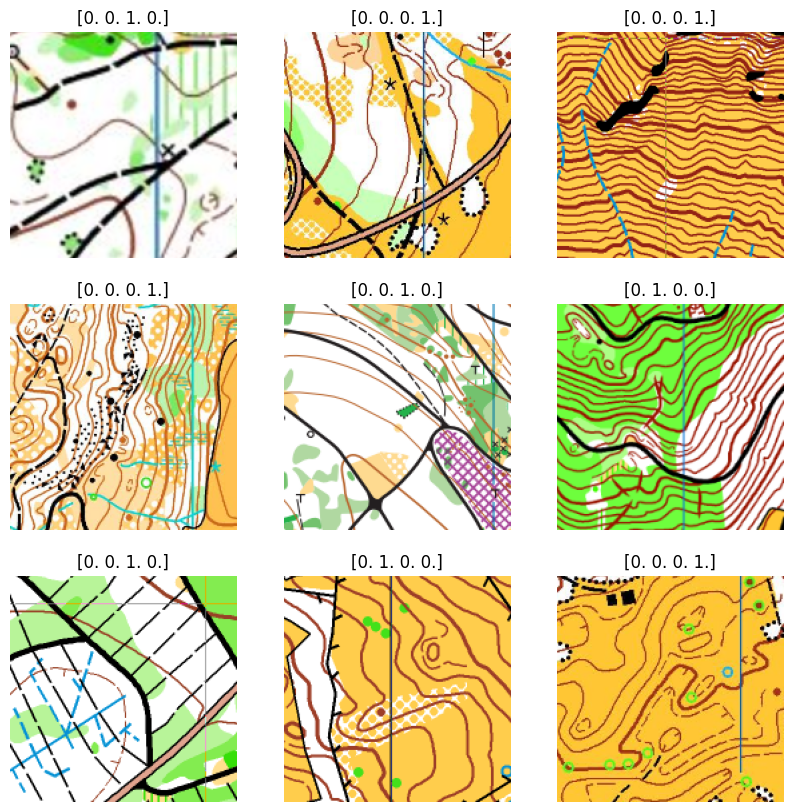

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(labels[i])[10:23])
        plt.axis("off")
print(images.shape)


## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

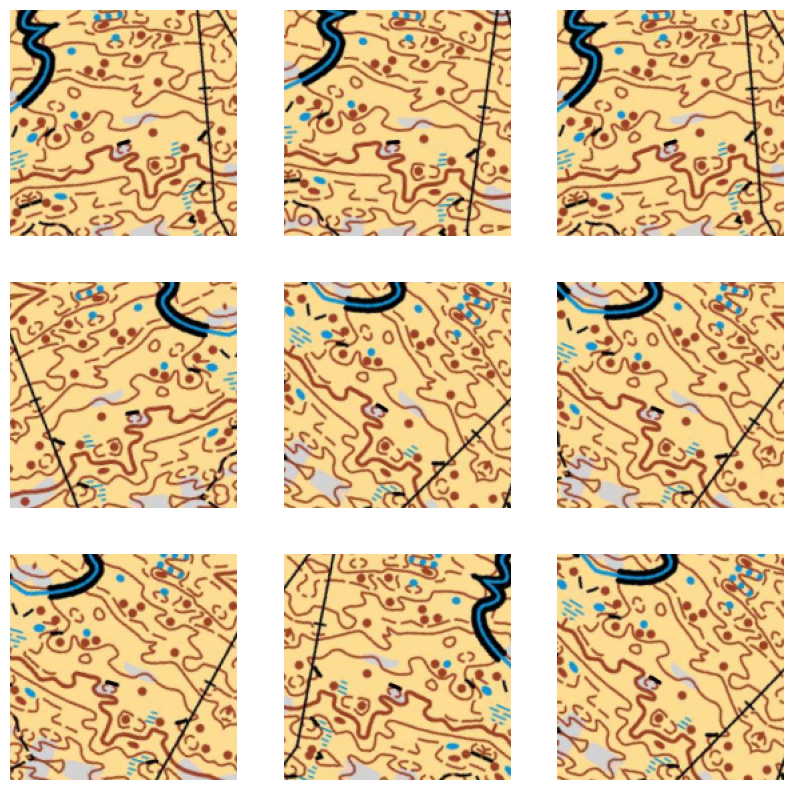

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

import warnings
# https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

## Configure the dataset for performance

Let's apply data augmentation to our training dataset, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using KerasTuner.

Note that:

We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
We include a Dropout layer before the final classification layer.

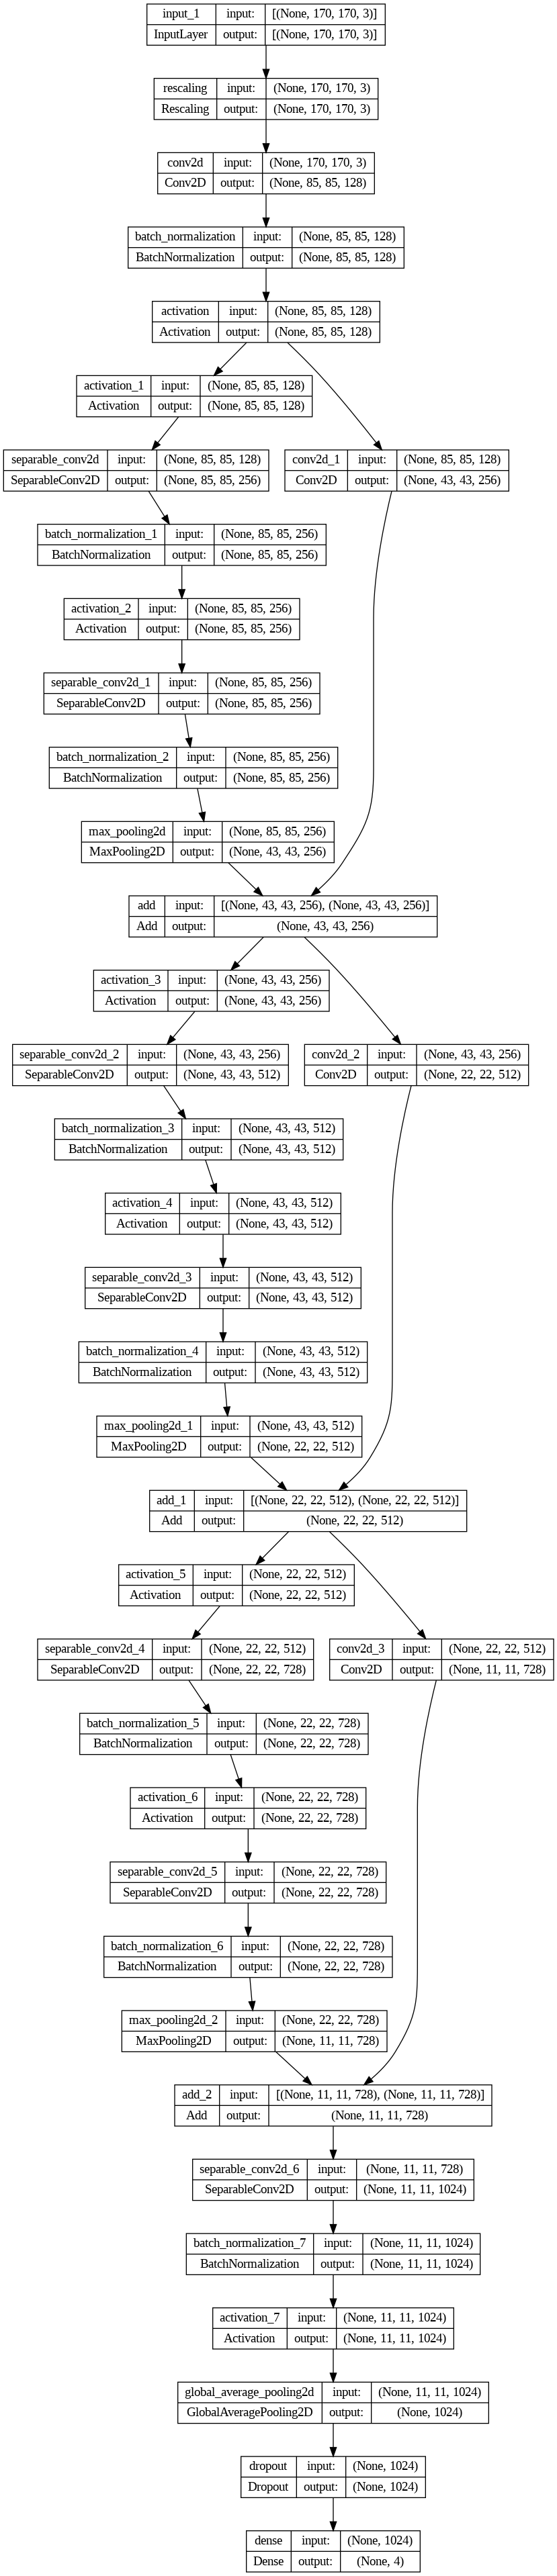

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs) #Standardisation
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=4)
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/My Drive/ColabNotebooks/Data/images_CNN/PR1_ModelCheckpoint_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/20
100/100 [==============================] - 546s 5s/step - loss: 0.7347 - accuracy: 0.7078 - val_loss: 1.3680 - val_accuracy: 0.3539
Epoch 2/20
100/100 [==============================] - 33s 325ms/step - loss: 0.5092 - accuracy: 0.8064 - val_loss: 1.3512 - val_accuracy: 0.3237
Epoch 3/20
100/100 [==============================] - 35s 335ms/step - loss: 0.4379 - accuracy: 0.8341 - val_loss: 1.3393 - val_accuracy: 0.3237
Epoch 4/20
100/100 [==============================] - 34s 325ms/step - loss: 0.4048 - accuracy: 0.8448 - val_loss: 1.3333 - val_accuracy: 0.3237
Epoch 5/20
100/100 [==============================] - 33s 321ms/step - loss: 0.3520 - accuracy: 0.8731 - val_loss: 1.2650 - val_accuracy: 0.3237
Epoch 6/20
100/100 [==============================] - 33s 320ms/step - loss: 0.3116 - accuracy: 0.8857 - val_loss: 1.1356 - val_accuracy: 0.5126
Epoch 7/20
100/100 [==============================] - 33s 322ms/step - loss: 0.3058 - accuracy: 0.8860 - val_loss: 0.6345 - val_accu

## Evaluation

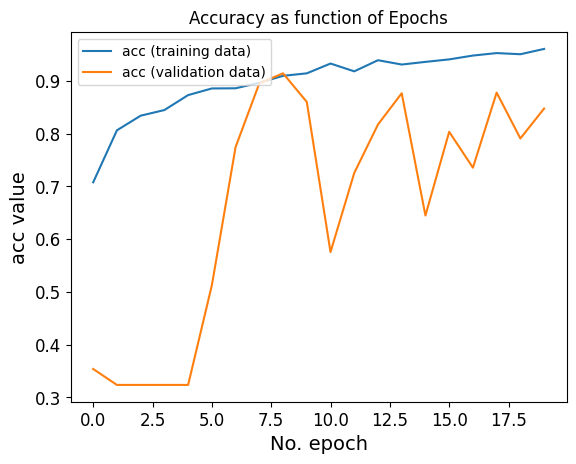

In [ ]:
# Plot the History of the Developement of the Accuracy

plt.plot(history.history['accuracy'], label='acc (training data)')
plt.plot(history.history['val_accuracy'], label='acc (validation data)')
plt.title('Accuracy as function of Epochs')
plt.ylabel('acc value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Load Modelparameters at a specific ModelCheckpoint

ModelCheckpoint = "/content/drive/My Drive/ColabNotebooks/Data/images_CNN/PR1_ModelCheckpoint_20.keras"

from keras.models import load_model
model = load_model(ModelCheckpoint)

In [ ]:
#Testing the Model with a Example (TestMap)

TestMap = "/content/drive/My Drive/ColabNotebooks/Data/images_transformer/unseen/EM01_0-0.png"

img = keras.preprocessing.image.load_img(TestMap
    , target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = list(predictions)
print(score[0][0])
print('Wahrscheinlichkeit der Zuordnung: \n'
     'alpin:       ', round(score[0][0],2), '\n'
     'jura:        ', round(score[0][1],2), '\n'
     'mittelland:  ', round(score[0][2],2), '\n'
     'voralpin:    ', round(score[0][3],2))

1/1 [==============================] - 1s 806ms/step
0.00034917364
Wahrscheinlichkeit der Zuordnung: 
alpin:        0.0 
jura:         0.02 
mittelland:   0.0 
voralpin:     0.97


## Using an alternative CNN

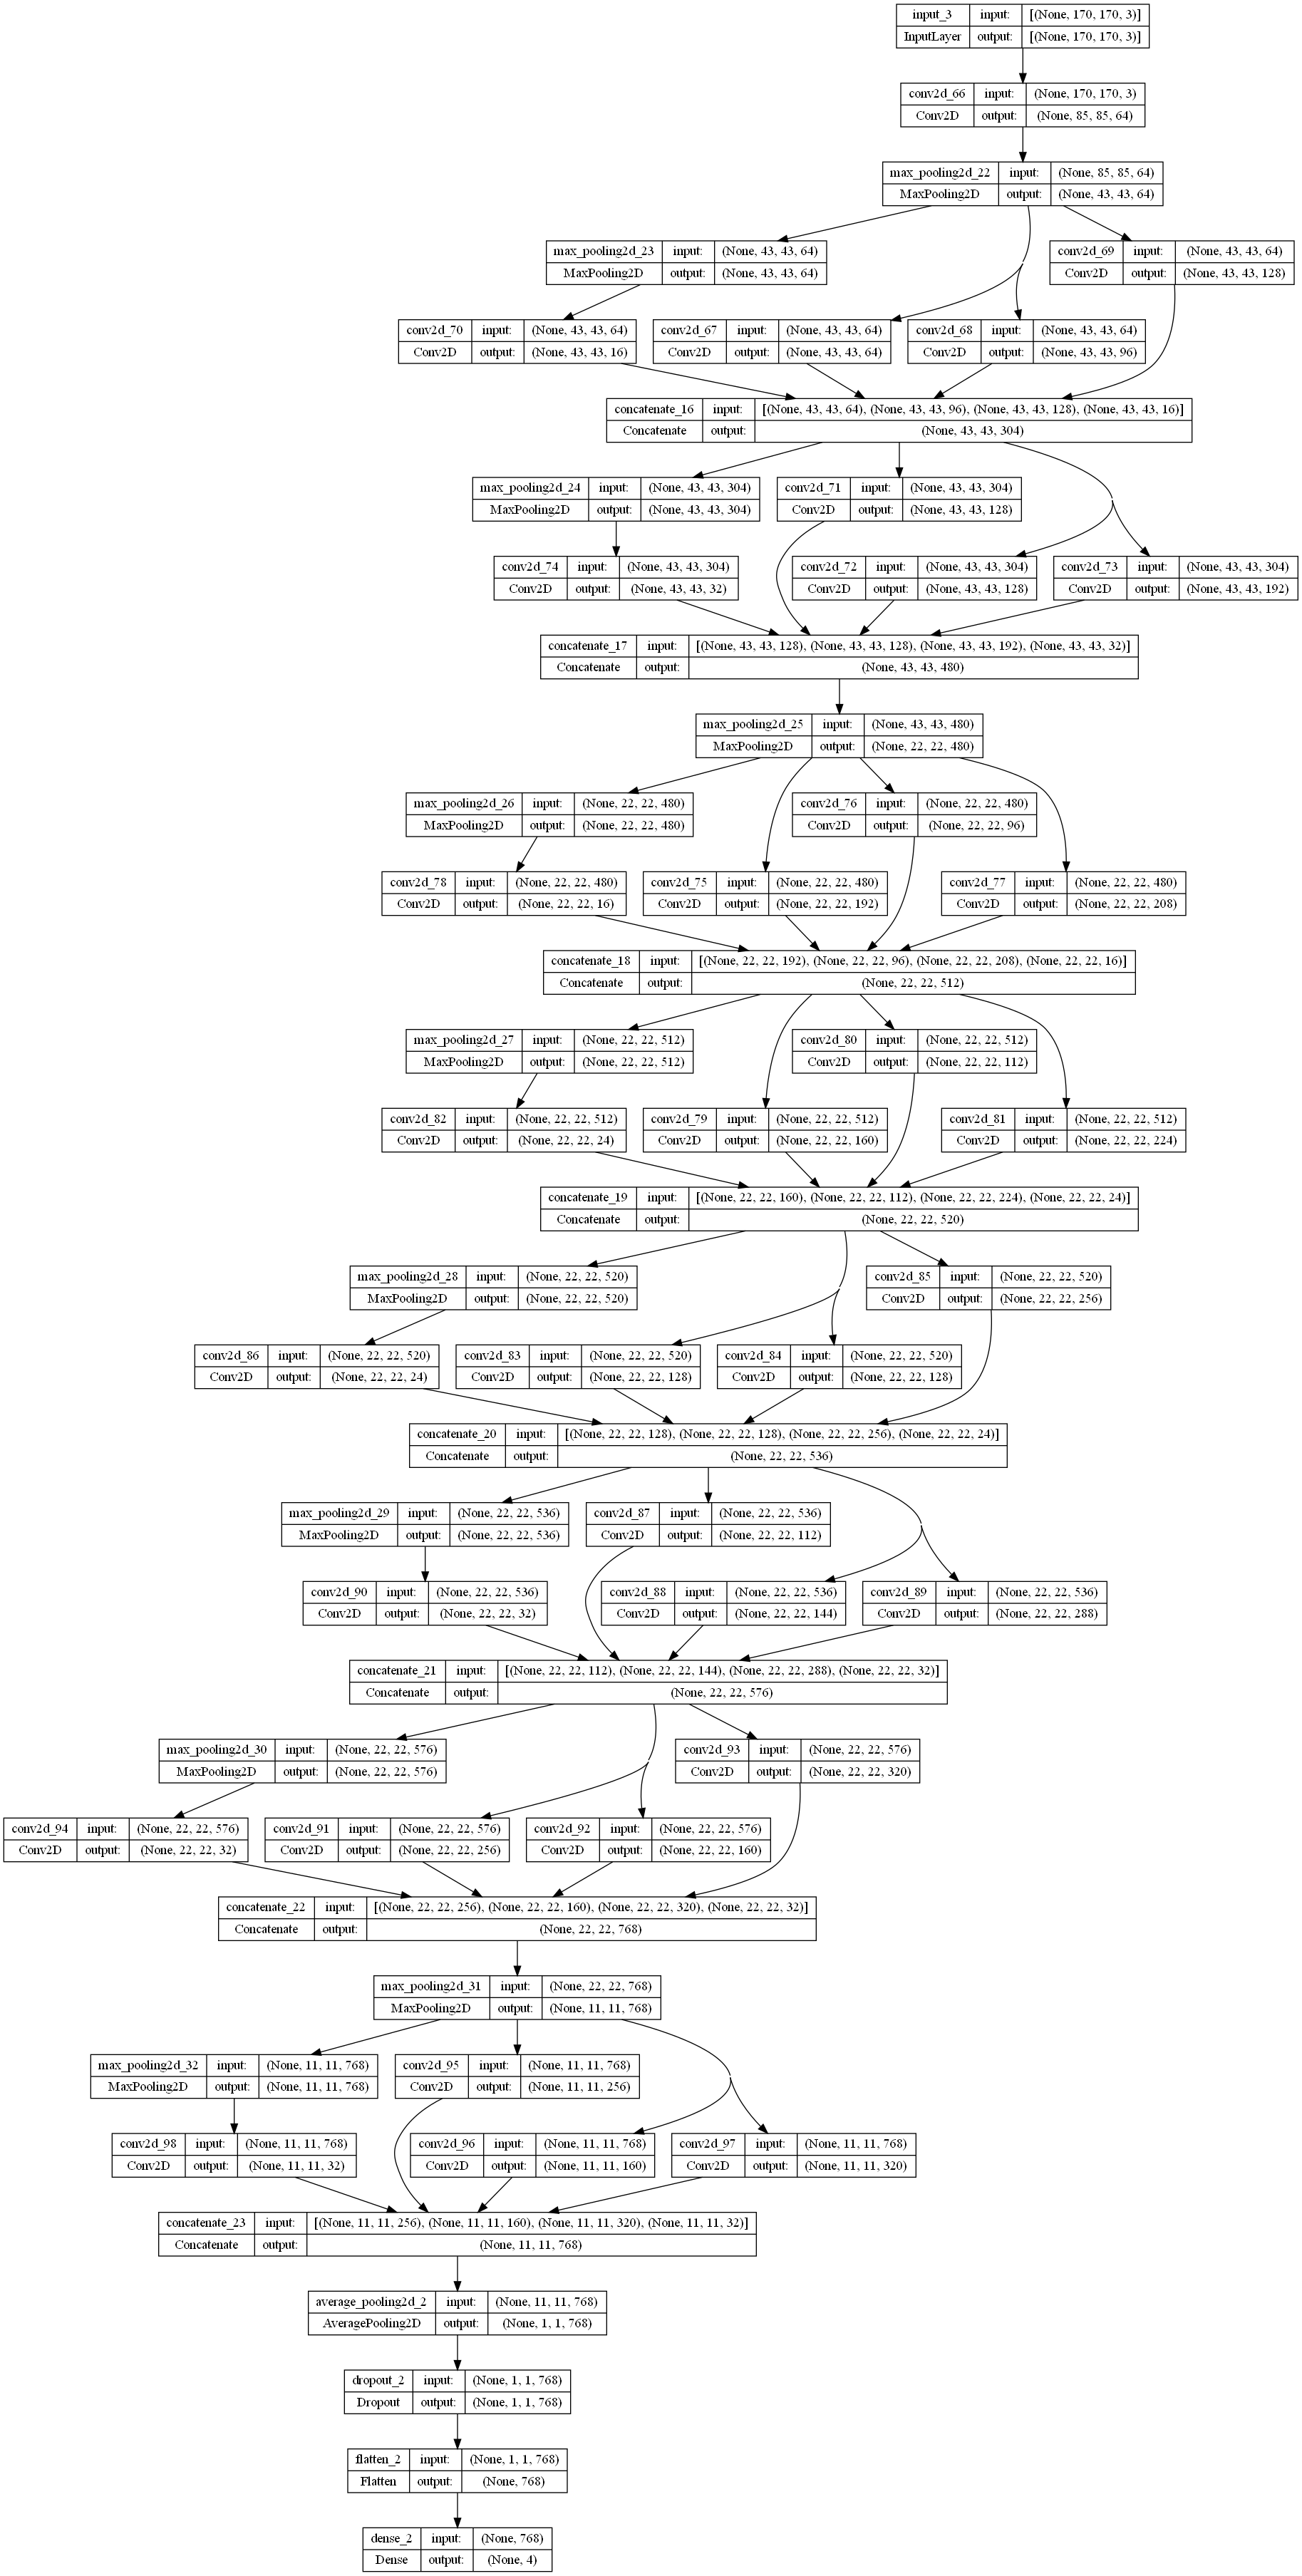

In [ ]:
#GoogLeNet

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, concatenate, AveragePooling2D, Flatten

def inception_module(x, filters):
    # 1x1 convolution
    conv1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 3x3 convolution
    conv3x3 = Conv2D(filters[1], (3, 3), padding='same', activation='relu')(x)

    # 5x5 convolution
    conv5x5 = Conv2D(filters[2], (5, 5), padding='same', activation='relu')(x)

    # Max pooling
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_conv = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(pool)

    # Concatenate
    output = concatenate([conv1x1, conv3x3, conv5x5, pool_conv], axis=-1)
    return output

input_layer = Input(shape=(170, 170, 3))

# Convolutional layer
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Inception modules
x = inception_module(x, [64, 96, 128, 16])
x = inception_module(x, [128, 128, 192, 32])
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_module(x, [192, 96, 208, 16])
x = inception_module(x, [160, 112, 224, 24])
x = inception_module(x, [128, 128, 256, 24])
x = inception_module(x, [112, 144, 288, 32])
x = inception_module(x, [256, 160, 320, 32])
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_module(x, [256, 160, 320, 32])

# Final layers
x = AveragePooling2D((7, 7))(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
output_layer = Dense(4, activation='softmax')(x)

# Create model
model = Model(input_layer, output_layer)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("PR1_GLN_ModelCheckpoint_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
94/94 [==============================] - 2098s 22s/step - loss: 1119.7357 - accuracy: 0.3381 - val_loss: 1.2238 - val_accuracy: 0.3861
Epoch 2/8
94/94 [==============================] - 2152s 23s/step - loss: 1.1545 - accuracy: 0.4648 - val_loss: 1.1088 - val_accuracy: 0.4866
Epoch 3/8
94/94 [==============================] - 2260s 24s/step - loss: 1.0135 - accuracy: 0.5245 - val_loss: 0.9991 - val_accuracy: 0.5335
Epoch 4/8
94/94 [==============================] - 2060s 22s/step - loss: 0.9820 - accuracy: 0.5623 - val_loss: 0.9148 - val_accuracy: 0.5804
Epoch 5/8
94/94 [==============================] - 2038s 22s/step - loss: 0.9053 - accuracy: 0.5912 - val_loss: 0.8903 - val_accuracy: 0.5831
Epoch 6/8
94/94 [==============================] - 2032s 22s/step - loss: 0.8934 - accuracy: 0.6086 - val_loss: 1.0283 - val_accuracy: 0.5710
Epoch 7/8
94/94 [==============================] - 2005s 21s/step - loss: 0.8383 - accuracy: 0.6394 - val_loss: 1.1109 - val_accuracy: 0.5040
Epo

In [ ]:
# Plot the History of the Developement of the Accuracy

plt.plot(history.history['accuracy'], label='acc (training data)')
plt.plot(history.history['val_accuracy'], label='acc (validation data)')
plt.title('Accuracy as function of Epochs')
plt.ylabel('acc value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

NameError: name 'history' is not defined

In [ ]:
# Load Modelparameters at a specific ModelCheckpoint

ModelCheckpoint = "PR1_GLN_ModelCheckpoint_8.keras"

from keras.models import load_model
model = load_model(ModelCheckpoint)

In [ ]:
#Testing the Model with a Example (TestMap)
image_size = (170, 170)
TestMap = "TestMaps/EM01_0-0.png"

img = keras.preprocessing.image.load_img(TestMap
    , target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = list(predictions)
print(score[0][0])
print('Wahrscheinlichkeit der Zuordnung: \n'
     'alpin:       ', round(score[0][0],2), '\n'
     'jura:        ', round(score[0][1],2), '\n'
     'mittelland:  ', round(score[0][2],2), '\n'
     'voralpin:    ', round(score[0][3],2))

1/1 [==============================] - 2s 2s/step
0.008864172
Wahrscheinlichkeit der Zuordnung: 
alpin:        0.01 
jura:         0.15 
mittelland:   0.07 
voralpin:     0.76
